In [1]:

import pandas as pd
import numpy as np
import random

# to build the MPL 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, Dense, Flatten, BatchNormalization,Dot,Dropout,Input, Concatenate
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

from tensorflow.keras.backend import variable, dot as k_dot,variable

from lifelines.utils import concordance_index
from sklearn import metrics
from sksurv.util import Surv
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

#HP optimizer
import optuna

# Data peparation
in this part we will load an prepare the data to create at the end the adajacency matrix to use for the model

In [2]:
#loading the data to format
X = np.load('./data/survival/X.npy')
X_columns = pd.read_csv('./data/survival/X_columns.csv',encoding='utf8').columns.tolist()
Y = np.load('./data/survival/Y.npy')
histo_type = pd.read_csv('./data/utils/histo.csv', index_col='RNA_ID',encoding='utf8')['type'].values

print ('number of patients in the raw data: ', len(X), 
       '\nnumber of genes in the raw data: ', len(X[0]))

number of patients in the raw data:  6873 
number of genes in the raw data:  22913


In [3]:
#load the data base PPIs to see the interactions
df= pd.read_csv('./data/ppi/PathwayCommons9.All.hgnc.txt',delimiter = "\t", engine='python',encoding='utf8')
df

,PARTICIPANT_A,INTERACTIONS_TYPE,PARTICIPANT_B
0,A1BG,interacts-with,ABCC6
1,A1BG,interacts-with,ACE2
2,A1BG,interacts-with,ADAM10
3,A1BG,interacts-with,ADAM17
4,A1BG,interacts-with,ADAM9
...,...,...,...
1546596,ZZZ3,controls-state-change-of,HIST1H3I
1546597,ZZZ3,controls-state-change-of,HIST1H3J
1546598,ZZZ3,controls-state-change-of,HIST2H3A
1546599,ZZZ3,controls-state-change-of,HIST2H3C


In [4]:
#LYMPHOCYTE
genes_lymphocites= pd.read_csv('data/ppi/T.cells.CD8.csv',delimiter = "\t", engine='python',encoding='utf8')["T.cells.CD8"].tolist()
len(genes_lymphocites)


66

In [5]:
#MACROPHAGE
genes_macrophages= pd.read_csv('data/ppi/Macrophages.csv',delimiter = "\t", engine='python',encoding='utf8')["Macrophages"].tolist()
len(genes_macrophages)


118

In [6]:
#NEUTROPHILS
genes_neutrophils= pd.read_csv('data/ppi/Neutrophils.csv',delimiter = "\t", engine='python',encoding='utf8')["Neutrophils"].tolist()
len(genes_neutrophils)


60

In [7]:
#Census
genes_Census= pd.read_csv('data/ppi/Census.csv',delimiter = "\t", engine='python',encoding='utf8')["Gene Symbol"].tolist()
len(genes_Census)

723

In [8]:
#fonction to create the adjacency matrix
def genes_selections_adj_matrix(df,X_columns,genes_lymphocites):
    
    #filter the dataframe with input patients RNA
    df= df[(df["PARTICIPANT_A"].isin(X_columns)) & (df["PARTICIPANT_B"].isin(X_columns))].reset_index(drop=True)
    df["INTERACTIONS_TYPE"]= 1
    
    #filter and a new data frame with lymphocites interactions
    dF= df[(df["PARTICIPANT_A"].isin(genes_lymphocites) & (df["PARTICIPANT_B"].isin(genes_lymphocites)))].reset_index(drop=True)
    
    B= dF['PARTICIPANT_B']
    A= dF['PARTICIPANT_A']
    
    #concatenate to have a matrix C(N,N)
    C = pd.concat([A,B])
    genes =pd.unique(C)
    
    #build the Adjacency Matrix
    #initialize the dame genes intercations to 0
    dtf_graph_tmp = pd.DataFrame({"PARTICIPANT_A": genes, "PARTICIPANT_B": genes , "INTERACTIONS_TYPE": 0})
    
    #Concatenate to have the same data frame
    dtf_graph1 = pd.concat((dF, dtf_graph_tmp)).sort_values(["PARTICIPANT_A", "PARTICIPANT_B"], ascending=True)
    dtf_graph1.reset_index(drop=True)
    
    #Adajcency matrix 
    dtf_graph = dtf_graph1.pivot_table(index="PARTICIPANT_A", columns="PARTICIPANT_B", values="INTERACTIONS_TYPE", fill_value=0).reset_index(drop=True)
    adj_matrix= np.array(dtf_graph)
    
    return adj_matrix
    

In [9]:
adj_matrix=genes_selections_adj_matrix(df,X_columns,genes_lymphocites)
print(adj_matrix.shape)

(30, 30)


In [10]:
adj_matrix1 =genes_selections_adj_matrix(df,X_columns,genes_macrophages)
print(adj_matrix1.shape)


(47, 47)


In [11]:
adj_matrix2=genes_selections_adj_matrix(df,X_columns,genes_neutrophils)
print(adj_matrix2.shape)

(16, 16)


In [12]:
adj_matrix3=genes_selections_adj_matrix(df,X_columns,genes_Census)
print(adj_matrix3.shape)

(669, 669)


In [13]:

def genes_to_use(df,X_columns,genes_lymphocites):
                                
    df= df[(df["PARTICIPANT_A"].isin(X_columns)) & (df["PARTICIPANT_B"].isin(X_columns))].reset_index(drop=True)
    df["INTERACTIONS_TYPE"]= 1
    
    #filter and a new data frame with lymphocites interactions
    dF= df[(df["PARTICIPANT_A"].isin(genes_lymphocites) & (df["PARTICIPANT_B"].isin(genes_lymphocites)))].reset_index(drop=True)
    
    B= dF['PARTICIPANT_B']
    A= dF['PARTICIPANT_A']
    
    #concatenate to have a matrix C(N,N)
    C = pd.concat([A,B])
    genes =pd.unique(C)
    
    return genes

In [14]:
#we can chose the genes to use for the model in inputs 
genes = genes_to_use(df,X_columns,genes_lymphocites)
genes1 = genes_to_use(df,X_columns,genes_macrophages)
genes2 = genes_to_use(df,X_columns,genes_neutrophils)
genes3 = genes_to_use(df,X_columns,genes_Census)
 

# Model
In this part we create 4 customer layer, for each lymphocites T genes set, to put the adjacency matrix inside 


In [15]:
# for genes lymphocyes immunity
dfX = pd.DataFrame(data=X, columns=X_columns)
dfX = dfX[genes]
X = dfX.values


print ('nb patients = ', len(dfX.values), "nb genes = ", len(dfX.values[1]))

nb patients =  6873 nb genes =  30


In [16]:
# (from DeepOS programme) drop the 5% of the patient with the highest survival, because considered as cured or deceased for an other reason 
Y_single_value = np.sum((Y == 1).astype('int32'), axis=1)
perc95 = np.percentile(Y_single_value, 95)
print ('number of patients removed: ', len(Y[Y_single_value > perc95, :int(perc95)]))

X = X[Y_single_value < perc95]
Y = Y[Y_single_value < perc95, :int(perc95)]
histo_type = histo_type[Y_single_value < perc95]

print('number of patients left: ', len(X))

number of patients removed:  344
number of patients left:  6529


In [17]:
# build the event array (1 if patient is non censored, 0 otherwise)
def get_censored_index(Y):
    censored_index = []
    non_censored_index = []
    for i in range(len(Y)):
        censored = False
        u = np.unique(Y[i])
        for v in u:
            if v != 0 and v != 1:
                censored = True
                break
        if censored:
            censored_index.append(i)
        else:
            non_censored_index.append(i)
    return non_censored_index, censored_index

non_censored_index, censored_index = get_censored_index(Y)

E = np.zeros(len(Y))
E[non_censored_index] = 1

In [18]:
RANDOM_SEED = 1234
NB_VAL = 800
NB_TEST = 800
NB_TRAIN = len (X) - NB_VAL - NB_TEST

indexes = np.arange(0, len(X), 1)
random.seed(RANDOM_SEED)
random.shuffle(indexes)
idx_train = indexes[:NB_TRAIN]
idx_val = indexes[NB_TRAIN:NB_TRAIN+NB_VAL]
idx_test = indexes[-NB_TEST:]

surv_X_train = X[idx_train]
surv_X_val = X[idx_val]
surv_X_test = X[idx_test]

surv_Y_train = Y[idx_train]
surv_Y_val = Y[idx_val]
surv_Y_test = Y[idx_test]

surv_E_train = E[idx_train]
surv_E_val = E[idx_val]
surv_E_test = E[idx_test]

In [19]:
"""Checking the shapes of the files"""
print ('Number of samples in X files: \ntraining set:', len (surv_X_train), 
       '\nvalidation set:', len (surv_X_val), '\ntest set:', len(surv_X_test))
print ('Number of samples in Y files: \ntraining set:', len (surv_Y_train), 
       '\nvalidation set:', len (surv_Y_val), '\ntest set:', len(surv_Y_test))
print ('number of genes:', len(surv_X_train[0]))

Number of samples in X files: 
training set: 4929 
validation set: 800 
test set: 800
Number of samples in Y files: 
training set: 4929 
validation set: 800 
test set: 800
number of genes: 30


In [20]:
input_shape= surv_X_train.shape[1]
output_shape=surv_Y_train.shape[1]

In [21]:
surv_X_train.shape

(4929, 30)

In [22]:
input_shape

30

In [23]:
     class Customerlayer(Layer): #Graph Hidden Layer with adjacency matrix multiplication with weigths 
    
        def __init__(self, nombre_units ,adj_matrix, activation = "relu",**kwargs):
       
                super(Customerlayer,self).__init__(**kwargs)
                self.nombre_units= nombre_units 
                self.activation =  activation 
                self.adj_matrix = variable(adj_matrix)
        

    
    # with this methode itd not necassay to initialize an input dimension 
        def build ( self , input_shape) :
       
                self.weight = self.add_weight(shape= [input_shape[-1],  self.nombre_units])
                self.biais = self.add_weight(shape = [self.nombre_units] ) 
          
        def call (self,input):
                    
         
            W= tf.keras.layers.Multiply()([self.weight,self.adj_matrix])
            return tf.matmul(input, W) + self.biais






In [24]:
# for genes lymphocites activations
Y1= np.load('./data/survival/Y.npy')
X1= np.load('./data/survival/X1.npy')
X1_columns = pd.read_csv('./data/survival/X1_columns.csv',encoding='utf8').columns.tolist()

dfX1 = pd.DataFrame(data=X1, columns=X1_columns)
dfX1= dfX1[genes1]
X1 = dfX1.values


print ('nb patients = ', len(dfX1.values), "nb genes = ", len(dfX1.values[1]))

nb patients =  6873 nb genes =  47


In [25]:
Y_single_value = np.sum((Y1 == 1).astype('int32'), axis=1)
perc95 = np.percentile(Y_single_value, 95)
print ('number of patients removed: ', len(Y1[Y_single_value > perc95, :int(perc95)]))

X1 = X1[Y_single_value < perc95]
Y1 = Y1[Y_single_value < perc95, :int(perc95)]


print('number of patients left: ', len(X1))

number of patients removed:  344
number of patients left:  6529


In [26]:
# build the event array (1 if patient is non censored, 0 otherwise)
def get_censored_index(Y1):
    censored_index = []
    non_censored_index = []
    for i in range(len(Y)):
        censored = False
        u = np.unique(Y[i])
        for v in u:
            if v != 0 and v != 1:
                censored = True
                break
        if censored:
            censored_index.append(i)
        else:
            non_censored_index.append(i)
    return non_censored_index, censored_index

non_censored_index, censored_index = get_censored_index(Y)

E1 = np.zeros(len(Y1))
E1[non_censored_index] = 1

In [27]:
RANDOM_SEED = 1234
NB_VAL = 800
NB_TEST = 800
NB_TRAIN = len (X1) - NB_VAL - NB_TEST

indexes = np.arange(0, len(X), 1)
random.seed(RANDOM_SEED)
random.shuffle(indexes)
idx_train = indexes[:NB_TRAIN]
idx_val = indexes[NB_TRAIN:NB_TRAIN+NB_VAL]
idx_test = indexes[-NB_TEST:]

surv_X1_train = X1[idx_train]
surv_X1_val = X1[idx_val]
surv_X1_test = X1[idx_test]

surv_Y1_train = Y1[idx_train]
surv_Y1_val = Y1[idx_val]
surv_Y1_test = Y1[idx_test]

surv_E1_train = E1[idx_train]
surv_E1_val = E1[idx_val]
surv_E1_test = E1[idx_test]

In [28]:
"""Checking the shapes of the files"""
print ('Number of samples in X files: \ntraining set:', len (surv_X1_train), 
       '\nvalidation set:', len (surv_X1_val), '\ntest set:', len(surv_X1_test))
print ('Number of samples in Y files: \ntraining set:', len (surv_Y1_train), 
       '\nvalidation set:', len (surv_Y1_val), '\ntest set:', len(surv_Y1_test))
print ('number of genes:', len(surv_X1_train[0]))

Number of samples in X files: 
training set: 4929 
validation set: 800 
test set: 800
Number of samples in Y files: 
training set: 4929 
validation set: 800 
test set: 800
number of genes: 47


In [29]:
input_shape1= surv_X1_train.shape[1]
output_shape=surv_Y_train.shape[1]

In [30]:
surv_Y_train.shape

(4929, 3561)

In [31]:
def mse_nan(y_true, y_pred):
    """
    MSE loss function that ignore the censored data
    
    y_true is the tensor with the real value
    y_pred is the tensor with the predicted value by the model
    y_true and y_pred have the same dimension
    all the censored data in y_true were previoulsy replaced by -1
    """
    
    # the two following lines create a mask filled with only 1 or 0
    # this mask have the same dimension as y_true
    # this mask will have a value of 1 if the value is non censored in y_true
    # otherwise, the corresponding value of a censored data will be 0 
    mask = tf.greater_equal(y_true, tf.constant([0.0], dtype = tf.float32))
    mask = tf.cast(mask, tf.float32)
    
    # Then we multiply y_true and y_pred with the mask.
    # This will replace the censored data point with 0 in both tensor.
    y_true = tf.multiply(y_true, mask)
    y_pred = tf.multiply(y_pred, mask)

    # now that every censored data is replaced by 0 in y_true and y_pred,
    # the MSE of those censored points will be 0.
    # The MSE of the non censored point stay the same
    nb_zero = tf.reduce_sum(tf.cast(tf.equal(y_true, 0), tf.float32))
    nb_non_masked = tf.cast(tf.size(y_true), tf.float32) - nb_zero
    mse_masked = (K.sum((y_true - y_pred)**2))/nb_non_masked

    return mse_masked

In [32]:
 class Customerlayer1(Layer): #Graph Hidden Layer with adjacency matrix multiplication with weigths 
    
        def __init__(self, nombre_units ,adj_matrix1, activation = "relu",**kwargs):
       
                super(Customerlayer1,self).__init__(**kwargs)
                self.nombre_units= nombre_units 
                self.activation =  activation 
                self.adj_matrix1 = variable(adj_matrix1)
              

    
    # with this methode itd not necassay to initialize an input dimension 
        def build ( self , input_shape) :
       
                self.weight = self.add_weight(shape= [input_shape[-1],  self.nombre_units])
                self.biais = self.add_weight(shape = [self.nombre_units] ) 
          
    
        def call (self,input):
                    
         
            W= tf.keras.layers.Multiply()([self.weight,self.adj_matrix1])
            return tf.matmul(input, W) + self.biais




In [33]:
# for genes lymphocites migrations
Y2= np.load('./data/survival/Y.npy')
X2= np.load('./data/survival/X1.npy')
X2_columns = pd.read_csv('./data/survival/X1_columns.csv',encoding='utf8').columns.tolist()

dfX2 = pd.DataFrame(data=X2, columns=X2_columns)
dfX2= dfX2[genes2]
X2 = dfX2.values


print ('nb patients = ', len(dfX2.values), "nb genes = ", len(dfX2.values[1]))

nb patients =  6873 nb genes =  16


In [34]:
Y_single_value = np.sum((Y2 == 1).astype('int32'), axis=1)
perc95 = np.percentile(Y_single_value, 95)
print ('number of patients removed: ', len(Y2[Y_single_value > perc95, :int(perc95)]))

X2 = X2[Y_single_value < perc95]
Y2 = Y2[Y_single_value < perc95, :int(perc95)]


print('number of patients left: ', len(X2))

number of patients removed:  344
number of patients left:  6529


In [35]:
# build the event array (1 if patient is non censored, 0 otherwise)
def get_censored_index(Y2):
    censored_index = []
    non_censored_index = []
    for i in range(len(Y2)):
        censored = False
        u = np.unique(Y[i])
        for v in u:
            if v != 0 and v != 1:
                censored = True
                break
        if censored:
            censored_index.append(i)
        else:
            non_censored_index.append(i)
    return non_censored_index, censored_index

non_censored_index, censored_index = get_censored_index(Y2)

E2 = np.zeros(len(Y2))
E2[non_censored_index] = 1

In [36]:
RANDOM_SEED = 1234
NB_VAL = 800
NB_TEST = 800
NB_TRAIN = len (X2) - NB_VAL - NB_TEST

indexes = np.arange(0, len(X2), 1)
random.seed(RANDOM_SEED)
random.shuffle(indexes)
idx_train = indexes[:NB_TRAIN]
idx_val = indexes[NB_TRAIN:NB_TRAIN+NB_VAL]
idx_test = indexes[-NB_TEST:]

surv_X2_train = X2[idx_train]
surv_X2_val = X2[idx_val]
surv_X2_test = X2[idx_test]

surv_Y2_train = Y2[idx_train]
surv_Y2_val = Y2[idx_val]
surv_Y2_test = Y2[idx_test]

surv_E2_train = E2[idx_train]
surv_E2_val = E2[idx_val]
surv_E2_test = E2[idx_test]

In [37]:
"""Checking the shapes of the files"""
print ('Number of samples in X files: \ntraining set:', len (surv_X2_train), 
       '\nvalidation set:', len (surv_X2_val), '\ntest set:', len(surv_X2_test))
print ('Number of samples in Y files: \ntraining set:', len (surv_Y2_train), 
       '\nvalidation set:', len (surv_Y2_val), '\ntest set:', len(surv_Y2_test))
print ('number of genes:', len(surv_X2_train[0]))

Number of samples in X files: 
training set: 4929 
validation set: 800 
test set: 800
Number of samples in Y files: 
training set: 4929 
validation set: 800 
test set: 800
number of genes: 16


In [38]:
input_shape2= surv_X2_train.shape[1]
output_shape=surv_Y_train.shape[1]

In [39]:
 class Customerlayer2(Layer): 
    
        def __init__(self, nombre_units ,adj_matrix2, activation = "relu",**kwargs):
       
                super(Customerlayer2,self).__init__(**kwargs)
                self.nombre_units= nombre_units 
                self.activation =  activation 
                self.adj_matrix2 = variable(adj_matrix2)
                

    
    # with this methode itd not necassay to initialize an input dimension 
        def build ( self , input_shape) :
       
                self.weight = self.add_weight(shape= [input_shape[-1],  self.nombre_units])
                self.biais = self.add_weight(shape = [self.nombre_units] ) 
       
        def call (self,input):
                    
         
            W= tf.keras.layers.Multiply()([self.weight,self.adj_matrix2])
            return tf.matmul(input, W) + self.biais




In [40]:
# for genes lymphocites migrations
Y3= np.load('./data/survival/Y.npy')
X3= np.load('./data/survival/X1.npy')
X3_columns = pd.read_csv('./data/survival/X1_columns.csv',encoding='utf8').columns.tolist()

dfX3 = pd.DataFrame(data=X3, columns=X3_columns)
dfX3= dfX3[genes3]
X3 = dfX3.values


print ('nb patients = ', len(dfX3.values), "nb genes = ", len(dfX3.values[1]))

nb patients =  6873 nb genes =  669


In [41]:
Y_single_value = np.sum((Y3 == 1).astype('int32'), axis=1)
perc95 = np.percentile(Y_single_value, 95)
print ('number of patients removed: ', len(Y3[Y_single_value > perc95, :int(perc95)]))

X3 = X3[Y_single_value < perc95]
Y3 = Y3[Y_single_value < perc95, :int(perc95)]


print('number of patients left: ', len(X2))

number of patients removed:  344
number of patients left:  6529


In [42]:
# build the event array (1 if patient is non censored, 0 otherwise)
def get_censored_index(Y3):
    censored_index = []
    non_censored_index = []
    for i in range(len(Y3)):
        censored = False
        u = np.unique(Y[i])
        for v in u:
            if v != 0 and v != 1:
                censored = True
                break
        if censored:
            censored_index.append(i)
        else:
            non_censored_index.append(i)
    return non_censored_index, censored_index

non_censored_index, censored_index = get_censored_index(Y2)

E3 = np.zeros(len(Y3))
E3[non_censored_index] = 1

In [43]:
RANDOM_SEED = 1234
NB_VAL = 800
NB_TEST = 800
NB_TRAIN = len (X3) - NB_VAL - NB_TEST

indexes = np.arange(0, len(X3), 1)
random.seed(RANDOM_SEED)
random.shuffle(indexes)
idx_train = indexes[:NB_TRAIN]
idx_val = indexes[NB_TRAIN:NB_TRAIN+NB_VAL]
idx_test = indexes[-NB_TEST:]

surv_X3_train = X3[idx_train]
surv_X3_val = X3[idx_val]
surv_X3_test = X3[idx_test]

surv_Y3_train = Y3[idx_train]
surv_Y3_val = Y3[idx_val]
surv_Y3_test = Y3[idx_test]

surv_E3_train = E3[idx_train]
surv_E3_val = E3[idx_val]
surv_E3_test = E3[idx_test]



"""Checking the shapes of the files"""
print ('Number of samples in X files: \ntraining set:', len (surv_X3_train), 
       '\nvalidation set:', len (surv_X3_val), '\ntest set:', len(surv_X3_test))
print ('Number of samples in Y files: \ntraining set:', len (surv_Y3_train), 
       '\nvalidation set:', len (surv_Y3_val), '\ntest set:', len(surv_Y3_test))
print ('number of genes:', len(surv_X3_train[0]))

Number of samples in X files: 
training set: 4929 
validation set: 800 
test set: 800
Number of samples in Y files: 
training set: 4929 
validation set: 800 
test set: 800
number of genes: 669


In [44]:
input_shape3= surv_X3_train.shape[1]
output_shape=surv_Y3_train.shape[1]

In [45]:
 class Customerlayer3(Layer): 
    
        def __init__(self, nombre_units ,adj_matrix3, activation = "relu",**kwargs):
       
                super(Customerlayer3,self).__init__(**kwargs)
                self.nombre_units= nombre_units 
                self.activation =  activation 
                self.adj_matrix3 = variable(adj_matrix3)
             

    
    # with this methode itd not necassay to initialize an input dimension 
        def build ( self , input_shape) :
       
                self.weight = self.add_weight(shape= [input_shape[-1],  self.nombre_units])
                self.biais = self.add_weight(shape = [self.nombre_units] ) 
           
        def call (self,input):
                    
         
            W= tf.keras.layers.Multiply()([self.weight,self.adj_matrix3])
            return tf.matmul(input, W) + self.biais




In [46]:
#inputs= (Input(shape= input_shape,))
#normalize = model.add(BatchNormalization())(input_shape)
#hidden1=(Customerlayer(input_shape,adj_matrix=adj_matrix, activation = 'relu'))(inputs)
#hidden2=(Customerlayer(input_shape,adj_matrix=adj_matrix, activation = 'relu'))(hidden1)

         

#outputs =(Customerlayer(output_shape,adj_matrix=adj_matrix, activation = 'softmax'))(hidden2)
#model=Model(inputs,outputs)

In [47]:
#inputs= (Input(shape= input_shape,))
#normalize = model.add(BatchNormalization())(input_shape)
#hidden1=(Customerlayer(input_shape,adj_matrix=adj_matrix, activation = 'relu'))(inputs)
#hidden2=(Customerlayer(input_shape,adj_matrix=adj_matrix, activation = 'relu'))(hidden1)

         

#outputs =(Customerlayer(output_shape,adj_matrix=adj_matrix, activation = 'softmax'))(hidden2)
#model2=Model(inputs,outputs)


In [48]:
#merged=  Concatenate()([model1,model2,model3])
#out=Dense(output_shape,ativation="softmax")

In [49]:
# MLP with customer layer
#nb_layers=5
#model=Sequential()
#inputs = model.add(Input(shape= input_shape,))
#normalize = model.add(BatchNormalization())
#to add input_layer
#for i in range (nb_layers):
    #hidden=model.add(Customerlayer1(input_shape,adj_matrix=adj_matrix, activation = 'relu'))



#outputs = model.add(Customerlayer(output_shape,adj_matrix=adj_matrix, activation = 'softmax'))




# Deep Learning Model
In this part we use 4 neural networks in parallel, and concatenate them at the end to have one model.

In [50]:
from tensorflow.keras import regularizers

In [151]:
nb_layers= 1
inputs= (Input(shape= input_shape,))
inputs1= (Input(shape= input_shape1,))
inputs2= (Input(shape= input_shape2,))
inputs3= (Input(shape= input_shape3,))


hidden =Dense(input_shape, activation = 'sigmoid',kernel_regularizer=regularizers.l1(l1=0.00000001))(inputs)
hidden=(Customerlayer(input_shape, adj_matrix=adj_matrix,activation = 'relu'))(hidden)

for i in range (nb_layers):
    hidden=(Customerlayer(input_shape, adj_matrix=adj_matrix,activation = 'relu'))(hidden)
    #Dropout=tf.keras.layers.Dropout(0.5)(hidden)
    

hidden1 =Dense(input_shape1, activation = 'sigmoid',kernel_regularizer=regularizers.l1(l1=0.00000001))(inputs1)
hidden1=(Customerlayer1(input_shape1, adj_matrix1=adj_matrix1,activation = 'relu'))(hidden1)

for i in range (nb_layers):
    hidden1=(Customerlayer1(input_shape1, adj_matrix1=adj_matrix1,activation = 'relu'))(hidden1)
    #Dropout=tf.keras.layers.Dropout(0.5)(hidden1)
    

    
hidden2 =Dense(input_shape2, activation = 'sigmoid',kernel_regularizer=regularizers.l1(l1=0.00000001))(inputs2)
hidden2=(Customerlayer2(input_shape2, adj_matrix2=adj_matrix2,activation = 'relu'))(hidden2)

for i in range (nb_layers):
    hidden2 =(Customerlayer2(input_shape2, adj_matrix2=adj_matrix2,activation = 'relu'))(hidden2)
    #Dropout=tf.keras.layers.Dropout(0.5)(hidden2)
    

hidden3=Dense(input_shape3, activation = 'sigmoid',kernel_regularizer=regularizers.l1(l1=0.00000001))(inputs3)    
hidden3=(Customerlayer3(input_shape3, adj_matrix3=adj_matrix3,activation = 'relu'))(hidden3)

for i in range (nb_layers):
    hidden3=(Customerlayer3(input_shape3, adj_matrix3=adj_matrix3,activation = 'relu'))(hidden3)
    #Dropout=tf.keras.layers.Dropout(0.5)(hidden3)
    
        
merged= tf.keras.layers.concatenate([hidden,hidden1,hidden2, hidden3])
final_weights=Dense(762, activation = 'sigmoid',kernel_regularizer=regularizers.l1(l1=0.00000001))(merged)
                               
outputs =Dense(output_shape, activation = 'sigmoid',kernel_regularizer=regularizers.l1(l1=0.00000001))(final_weights)


model=Model(inputs=[inputs,inputs1,inputs2,inputs3],outputs = [outputs])

In [152]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_66 (InputLayer)           [(None, 47)]         0                                            
__________________________________________________________________________________________________
input_67 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_68 (InputLayer)           [(None, 669)]        0                                            
___________________________________________________________________________________________

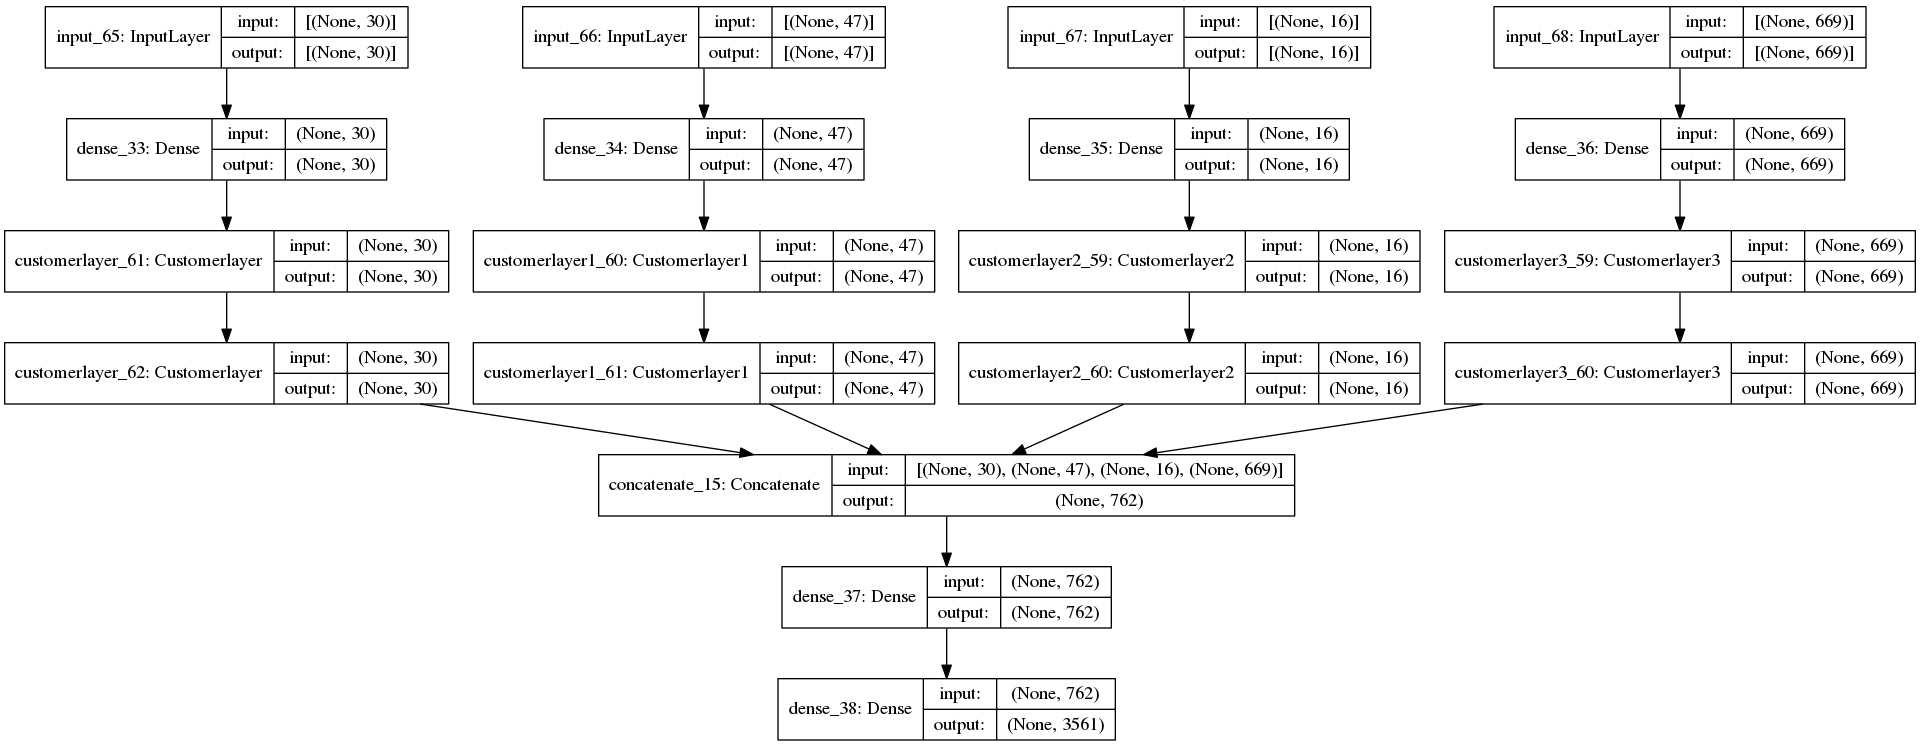

In [153]:
plot_model(model,'model2_new.png',  show_shapes=True)
#plot_model(model,'model2_new.png')

In [154]:
opt = Adam(learning_rate=0.0001, decay=1e-6)
model.compile(optimizer= opt ,loss= mse_nan)

In [160]:
history = model.fit( x=[surv_X_train,surv_X1_train,surv_X2_train,surv_X3_train], y=[surv_Y_train], validation_data = ([surv_X_val,surv_X1_val,surv_X2_val,surv_X3_val],surv_Y_val),epochs = 300, batch_size = 29)

Epoch 1/300
170/170 [==============================] - 4s 24ms/step - loss: 0.2670 - val_loss: 0.2751
Epoch 2/300
170/170 [==============================] - 4s 26ms/step - loss: 0.2660 - val_loss: 0.2507
Epoch 3/300
170/170 [==============================] - 4s 25ms/step - loss: 0.2660 - val_loss: 0.2517
Epoch 4/300
170/170 [==============================] - 4s 26ms/step - loss: 0.2621 - val_loss: 0.2535
Epoch 5/300
170/170 [==============================] - 4s 26ms/step - loss: 0.2630 - val_loss: 0.2508
Epoch 6/300
170/170 [==============================] - 4s 26ms/step - loss: 0.2647 - val_loss: 0.2586
Epoch 7/300
170/170 [==============================] - 4s 25ms/step - loss: 0.2618 - val_loss: 0.2505
Epoch 8/300
170/170 [==============================] - 4s 24ms/step - loss: 0.2632 - val_loss: 0.2508
Epoch 9/300
170/170 [==============================] - 4s 25ms/step - loss: 0.2618 - val_loss: 0.2496
Epoch 10/300
170/170 [==============================] - 4s 25ms/step - loss: 0.263

170/170 [==============================] - 4s 23ms/step - loss: 0.2492 - val_loss: 0.2450
Epoch 160/300
170/170 [==============================] - 4s 23ms/step - loss: 0.2486 - val_loss: 0.2491
Epoch 161/300
170/170 [==============================] - 4s 23ms/step - loss: 0.2495 - val_loss: 0.2550
Epoch 162/300
170/170 [==============================] - 4s 23ms/step - loss: 0.2492 - val_loss: 0.2429
Epoch 163/300
170/170 [==============================] - 4s 25ms/step - loss: 0.2490 - val_loss: 0.2500
Epoch 164/300
170/170 [==============================] - 4s 23ms/step - loss: 0.2481 - val_loss: 0.2436
Epoch 165/300
170/170 [==============================] - 4s 24ms/step - loss: 0.2501 - val_loss: 0.2421
Epoch 166/300
170/170 [==============================] - 4s 24ms/step - loss: 0.2471 - val_loss: 0.2432
Epoch 167/300
170/170 [==============================] - 4s 23ms/step - loss: 0.2502 - val_loss: 0.2507
Epoch 168/300
170/170 [==============================] - 4s 23ms/step - loss: 

Epoch 238/300
170/170 [==============================] - 4s 25ms/step - loss: 0.2441 - val_loss: 0.2541
Epoch 239/300
170/170 [==============================] - 4s 23ms/step - loss: 0.2463 - val_loss: 0.2409
Epoch 240/300
170/170 [==============================] - 4s 24ms/step - loss: 0.2438 - val_loss: 0.2453
Epoch 241/300
170/170 [==============================] - 4s 23ms/step - loss: 0.2437 - val_loss: 0.2481
Epoch 242/300
170/170 [==============================] - 4s 23ms/step - loss: 0.2436 - val_loss: 0.2489
Epoch 243/300
170/170 [==============================] - 4s 25ms/step - loss: 0.2438 - val_loss: 0.2470
Epoch 244/300
170/170 [==============================] - 4s 25ms/step - loss: 0.2442 - val_loss: 0.2530
Epoch 245/300
170/170 [==============================] - 4s 23ms/step - loss: 0.2442 - val_loss: 0.2591
Epoch 246/300
170/170 [==============================] - 4s 23ms/step - loss: 0.2472 - val_loss: 0.2407
Epoch 247/300
170/170 [==============================] - 4s 24ms

# Results 


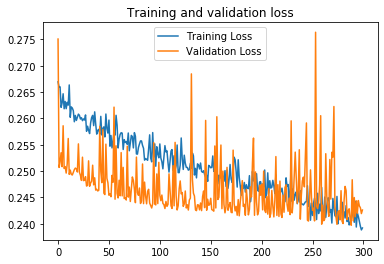

In [161]:
#to check the overfiting 
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()

plt.plot( loss,  label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [162]:
#compute the OS from the model prediction
def compute_os(arr):
    """Determine OS from the model predictions"""
    os = np.zeros(arr.shape[:-1])
    for i in range(arr.shape[0]):
        os[i] = (arr[i] > 0.5).astype('int32').sum()
    return os

In [163]:
#c-index for training validation and prediction
pred_val = model.predict([surv_X_val,surv_X1_val,surv_X2_val,surv_X3_val])
pred_val = compute_os(pred_val)
pred_train = model.predict([surv_X_train,surv_X1_train,surv_X2_train,surv_X3_train])
pred_train = compute_os(pred_train)
#pred_test= model.predict(surv_X_test)
#pred_test= compute_os(pred_test)
    
truth_val = compute_os(surv_Y_val)
truth_train = compute_os(surv_Y_train)
#truth = compute_os(surv_Y_test)

#truth_test = compute_os(surv_Y_test)

c_index_validation = concordance_index(truth_val, pred_val,surv_E_val)
c_index_train = concordance_index(truth_train, pred_train,surv_E_train)
#c_index_test = concordance_index(truth_test,pred_test)
    

In [164]:
print("C_index sur le train:      ",  c_index_train)
print("C_index sur la validation: ",c_index_validation)
#print("C_index sur le test:       ",      c_index_test)


C_index sur le train:       0.7628796878085102
C_index sur la validation:  0.7515916930349378


# learning curves 

 # Anlyse of the "Graph  Hidden Layers"

In [109]:
W1 = model.get_weights()[1]
W2 = model.get_weights()[3]
W3 = model.get_weights()[7]
W4 = model.get_weights()[9]
W5 = model.get_weights()[24]
W5.shape

(762, 762)

In [189]:
adj_matrix= tf.cast(adj_matrix, tf.float32)
adj_matrix1= tf.cast(adj_matrix1, tf.float32)
adj_matrix2= tf.cast(adj_matrix2, tf.float32)
adj_matrix3= tf.cast(adj_matrix3, tf.float32)


In [113]:
T=np.concatenate([genes,genes1,genes2,genes3])
len(T)

762

In [115]:
a=genes_selections_adj_matrix(df,X_columns,T)
len(a)

750

In [117]:
#Weights= tf.keras.layers.Multiply()([W1,adj_matrix])
#Weights1= tf.keras.layers.Multiply()([W2,adj_matrix1])
#Weights2= tf.keras.layers.Multiply()([W3,adj_matrix2])
#Weights3= tf.keras.layers.Multiply()([W4,adj_matrix3])

In [200]:
#transforme the tensor in Numpy array
#weight = Weights.numpy()
#weight1 = Weights1.numpy()
#weight2 = Weights2.numpy()
#weight3 = Weights3.numpy()

In [118]:
#weight.shape

In [119]:
#tabular lymphocites immunity
#df_weights= pd.DataFrame(index =genes,  columns=genes , data= weight)
#df_weights

NameError: name 'weight' is not defined

In [290]:
# tabular lymphocites_activation
#df_weights1= pd.DataFrame(index =genes1,  columns=genes1 , data= weight1)
#df_weights1

,ACTN2,ANKRD1,CAPN3,CAV3,CFL2,CSRP3,KLHL41,KRT19,LDB3,MYH3,...,TNNT2,TNNT3,TPM1,SYNPO2L,TTN,EDN1,KRT8,CASQ1,CSRP1,WDR1
ACTN2,-0.0,0.0,-0.0,-0.0000,1.139448,0.000000,0.000000,1.196661,0.000000,-0.0,...,-0.0,-0.0,0.718618,0.703441,0.674579,1.088196,1.194428,0.898214,0.922821,0.000000
ANKRD1,0.0,0.0,-0.0,-0.0000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.0,...,0.0,-0.0,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,1.087418,0.000000
CAPN3,-0.0,0.0,0.0,-0.0000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.0,...,0.0,0.0,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,1.013551,-0.000000
CAV3,-0.0,0.0,-0.0,-0.0000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.0,...,0.0,0.0,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000
CFL2,-0.0,0.0,0.0,0.0000,0.000000,-0.000000,0.000000,0.000000,1.003311,-0.0,...,-0.0,0.0,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000
CSRP3,-0.0,0.0,-0.0,0.0000,-0.000000,0.000000,-0.000000,1.373260,-0.000000,0.0,...,-0.0,0.0,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000
KLHL41,-0.0,0.0,-0.0,0.0000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
KRT19,-0.0,-0.0,-0.0,0.0000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.0,...,0.0,-0.0,-0.000000,1.052907,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
LDB3,0.0,-0.0,0.0,0.0000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.0,...,0.0,0.0,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
MYH3,0.0,0.0,0.0,0.0000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.0,...,0.0,0.0,-0.000000,1.074525,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000


In [291]:
# tabular lymphocites_migration
#df_weights2 = pd.DataFrame(index =genes2,  columns=genes2 , data= weight2)
df_weights2

,ABCC3,ABLIM1,AHNAK,ALDH2,ALDH3B2,ANK3,AP1G2,AREG,ARHGAP32,ASPA,...,KLF4,SOX15,S100P,TXNIP,TPD52L1,CLIC3,TP53AIP1,NFIB,PLP2,PLXNC1
ABCC3,-0.0,0.0,-0.0,0.0,-0.0,-0.00000,0.000000,0.000000,-0.0,0.0,...,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0
ABLIM1,-0.0,-0.0,0.0,-0.0,-0.0,-0.05919,-0.000000,-0.000000,0.0,-0.0,...,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0
AHNAK,0.0,-0.0,-0.0,-0.0,0.0,-0.00000,0.000000,0.000000,-0.0,-0.0,...,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0
ALDH2,0.0,-0.0,-0.0,-0.0,-0.0,0.00000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0
ALDH3B2,-0.0,0.0,-0.0,0.0,0.0,-0.00000,0.000000,-0.000000,0.0,0.0,...,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CLIC3,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00000,-0.000000,0.000000,0.0,0.0,...,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0
TP53AIP1,-0.0,-0.0,-0.0,0.0,0.0,0.00000,0.000000,-0.000000,-0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0
NFIB,-0.0,-0.0,0.0,-0.0,-0.0,-0.00000,0.217412,-0.161006,0.0,0.0,...,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0
PLP2,-0.0,0.0,-0.0,0.0,-0.0,-0.00000,0.000000,-0.000000,0.0,-0.0,...,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0


In [292]:
#tabular lymphocites_network
df_weights3 = pd.DataFrame(index =genes3,  columns=genes3 , data= weight3)
df_weights3

,ABTB2,AOC1,ARHGEF17,AURKA,BAIAP2L1,BCL2L1,CAMK1D,CASZ1,CDK2,CDKN1A,...,ALG2,APOL1,PPP2R3A,TNFAIP6,S1PR1,ZBTB5,TNFAIP1,CREB5,FOXP1,HEXIM1
ABTB2,-0.000000,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.000000,0.0,0.0
AOC1,-0.000000,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.000000,-0.0,-0.0
ARHGEF17,0.948567,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.990231,0.0,0.0
AURKA,-0.000000,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,...,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.000000,-0.0,-0.0
BAIAP2L1,0.000000,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZBTB5,0.000000,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.000000,0.0,-0.0
TNFAIP1,0.000000,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,...,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.000000,-0.0,-0.0
CREB5,-0.000000,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,...,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.000000,0.0,-0.0
FOXP1,0.000000,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.000000,-0.0,-0.0


In [86]:
# the  10 huge weights in the GNN: genes_jaeger_metastasis
maxV = df_weights2.max()
analyse= pd.DataFrame({ 'max value':maxV})
analyse.sort_values(by='max value',ascending=False)
maxv=analyse["max value"] = analyse[analyse["max value"] > 0.0 ]["max value"]


Analyse= pd.DataFrame({ 'max weights':maxv})
A=Analyse.sort_values(by='max weights',ascending=False)
A=A.iloc[:10]
A

,max weights
PTPRZ1,0.474491
FAT2,0.398126
ABCA12,0.382767
LSR,0.360003
AP1G2,0.331618
CST6,0.327937
HLF,0.325306
CALML3,0.323475
TFAP2B,0.322779
LTB4R,0.315034


In [88]:
# the  10 huge weights in the GNN: genes_untreated_macrophages
maxV = df_weights3.max()
analyse= pd.DataFrame({ 'max value':maxV})
analyse.sort_values(by='max value',ascending=False)
maxv=analyse["max value"] = analyse[analyse["max value"] > 0.0 ]["max value"]


Analyse= pd.DataFrame({ 'max weights':maxv})
A=Analyse.sort_values(by='max weights',ascending=False)
A=A.iloc[:10]
A

,max weights
MAP3K1,1.250027
CEP135,1.242934
SUZ12,1.215261
IL15RA,1.206733
SEMA7A,1.202838
KLC2,1.202484
ZADH2,1.199366
CDKN1A,1.196166
TTK,1.184425
LRCH3,1.170752


In [104]:
#this line of allow us t o find the interact genes for the tabular : genes_lymphocites_immunity
A=df_weights["IL27RA"] = df_weights[df_weights["IL27RA"] > 0.0 ]["IL27RA"]

print('interagis avec le gène:',A.idxmax(axis = 0),"===>", 'weights max',max(A))


interagis avec le gène: LEP ===> weights max 0.5773404240608215


In [105]:
#genes_lymphocites_immunity
data={ 'genes_A': ['IL27RA','CADM1','ULBP1', 'IGLL5','LAMP1','IL18RAP','CD27','IL18R1','LIG4','MSH2' ],'Weights':[0.577,0.559,0.543,0.528,0.521,0.499,0.472,0.452,0.446,0.466],'gene_B':['LEP','C8G','CR2', 'IGLL1','RAET1E','ARG2','LEP','IL13RA2','LEP','IFNB1' ]}
final_analyse = pd.DataFrame(data)
final_analyse

,genes_A,Weights,gene_B
0,IL27RA,0.577,LEP
1,CADM1,0.559,C8G
2,ULBP1,0.543,CR2
3,IGLL5,0.528,IGLL1
4,LAMP1,0.521,RAET1E
5,IL18RAP,0.499,ARG2
6,CD27,0.472,LEP
7,IL18R1,0.452,IL13RA2
8,LIG4,0.446,LEP
9,MSH2,0.466,IFNB1


# Hyperparameters optimization with optuna 

In [61]:
#HP optimization


def objective1(trial):
    
    #history = model.fit( x=[surv_X_train,surv_X1_train,surv_X2_train,surv_X3_train], y=[surv_Y_train], validation_data = ([surv_X_val,surv_X1_val,surv_X2_val,surv_X3_val],surv_Y_val),epochs = 100, batch_size = 29)
    param={   
    'epochs': trial.suggest_int('epochs',100,500),
    'batch_size': trial.suggest_float('batch_size',10e1,10e10),
    'learning_rate': trial.suggest_loguniform('learning_rate',10e-15,0.01),
    'nb_layers': trial.suggest_int('nb_layers',1,10),
    'l1': trial.suggest_uniform('l1',10e-15,0.01),
    }
    
    score = model.evaluate(x=[surv_X_train,surv_X1_train,surv_X2_train,surv_X3_train], y=[surv_Y_train], verbose=2)
    #nb_layers=trial.suggest_float('nb_layers',5,50)
    #compute the OS from the model prediction
    
    #c-index for training validation and prediction
    #pred_val = model.predict([surv_X_val,surv_X1_val,surv_X2_val,surv_X3_val])
    #pred_val = compute_os(pred_val)
    #pred_train = model.predict([surv_X_train,surv_X1_train,surv_X2_train,surv_X3_train])
    #pred_train = compute_os(pred_train)
    #pred_test= model.predict(surv_X_test)
    #pred_test= compute_os(pred_test)
    
    #truth_val = compute_os(surv_Y_val)
    #truth_train = compute_os(surv_Y_train)
    #truth = compute_os(surv_Y_test)

    #truth_test = compute_os(surv_Y_test)

    #c_index_val = concordance_index(truth_val, pred_val,surv_E_val)
    #c_index_train = concordance_index(truth_train, pred_train,surv_E_train)
    #c_index_test = concordance_index(truth_test,pred_test)
    
    #etrics = {'Training':{'C-index':  '%.5f'%c_index_train},
                #'Validation':{'C-index': '%.5f'%c_index_val}}
    
    #print(metrics)
    #model.save('./model/best_model/trial.h5')
    #learning_rate.save('./model/best_lr/lr.h5')
    return score
 
    
   

In [63]:
study = optuna.create_study(direction='maximize')
#study = optuna.create_study(direction='maximize', study_name="starter-experiment", storage='sqlite:///starter.db')
study.optimize(objective1, n_trials=10)

trial = study.best_trial


print("Best hyperparameters: {}".format(trial.params))

[I 2021-08-30 16:44:35,462] A new study created in memory with name: no-name-a6e07918-94c2-4d22-a6ed-58a3be3e6cdd


155/155 - 1s - loss: 0.2492


[I 2021-08-30 16:44:36,665] Trial 0 finished with value: 0.2491748034954071 and parameters: {'epochs': 201, 'batch_size': 40304073676.26353, 'learning_rate': 8.150749002682066e-06, 'nb_layers': 6, 'l1': 0.003185782336806184}. Best is trial 0 with value: 0.2491748034954071.


155/155 - 1s - loss: 0.2492


[I 2021-08-30 16:44:37,844] Trial 1 finished with value: 0.2491748034954071 and parameters: {'epochs': 152, 'batch_size': 83406405474.69269, 'learning_rate': 1.5247280387606858e-06, 'nb_layers': 6, 'l1': 0.002032065654519258}. Best is trial 0 with value: 0.2491748034954071.


155/155 - 1s - loss: 0.2492


[I 2021-08-30 16:44:39,160] Trial 2 finished with value: 0.2491748034954071 and parameters: {'epochs': 350, 'batch_size': 57671945093.07967, 'learning_rate': 3.0920221493213165e-12, 'nb_layers': 4, 'l1': 0.00599057220342532}. Best is trial 0 with value: 0.2491748034954071.


155/155 - 1s - loss: 0.2492


[I 2021-08-30 16:44:40,425] Trial 3 finished with value: 0.2491748034954071 and parameters: {'epochs': 496, 'batch_size': 69941080770.21234, 'learning_rate': 1.4729748875259648e-14, 'nb_layers': 7, 'l1': 0.0016707016505169352}. Best is trial 0 with value: 0.2491748034954071.


155/155 - 1s - loss: 0.2492


[I 2021-08-30 16:44:41,599] Trial 4 finished with value: 0.2491748034954071 and parameters: {'epochs': 157, 'batch_size': 24658919967.853825, 'learning_rate': 4.122314288525706e-05, 'nb_layers': 9, 'l1': 0.00785763511127543}. Best is trial 0 with value: 0.2491748034954071.


155/155 - 1s - loss: 0.2492


[I 2021-08-30 16:44:42,886] Trial 5 finished with value: 0.2491748034954071 and parameters: {'epochs': 444, 'batch_size': 46384242313.8502, 'learning_rate': 2.4682199587825788e-05, 'nb_layers': 5, 'l1': 0.00631049394530574}. Best is trial 0 with value: 0.2491748034954071.


155/155 - 1s - loss: 0.2492


[I 2021-08-30 16:44:44,064] Trial 6 finished with value: 0.2491748034954071 and parameters: {'epochs': 439, 'batch_size': 18007647784.887398, 'learning_rate': 3.0821986191550233e-13, 'nb_layers': 6, 'l1': 0.0006606154839602486}. Best is trial 0 with value: 0.2491748034954071.


155/155 - 1s - loss: 0.2492


[I 2021-08-30 16:44:45,311] Trial 7 finished with value: 0.2491748034954071 and parameters: {'epochs': 115, 'batch_size': 452248139.8956543, 'learning_rate': 5.481983646809803e-08, 'nb_layers': 6, 'l1': 7.746866088818741e-05}. Best is trial 0 with value: 0.2491748034954071.


155/155 - 1s - loss: 0.2492


[I 2021-08-30 16:44:46,519] Trial 8 finished with value: 0.2491748034954071 and parameters: {'epochs': 347, 'batch_size': 80552801366.30841, 'learning_rate': 9.40858408829081e-08, 'nb_layers': 7, 'l1': 0.0035313793624537847}. Best is trial 0 with value: 0.2491748034954071.


155/155 - 1s - loss: 0.2492


[I 2021-08-30 16:44:47,672] Trial 9 finished with value: 0.2491748034954071 and parameters: {'epochs': 352, 'batch_size': 29415668401.488163, 'learning_rate': 1.2587345142428394e-08, 'nb_layers': 8, 'l1': 0.003951939391029948}. Best is trial 0 with value: 0.2491748034954071.


Best hyperparameters: {'epochs': 201, 'batch_size': 40304073676.26353, 'learning_rate': 8.150749002682066e-06, 'nb_layers': 6, 'l1': 0.003185782336806184}
